# FP

## v2 - softmax 2, pandas, 
## next v3 - GAN , embeddings and visualization:  tensorboard and ...matplot

Start writing all my logic in jupyter notebook in order to run them from anaconda! <br>
** IMPORTANT ** <br>
the network cell should only be intialize once! otherwise the program start creating indexes for the variables!!!! 

tensorboard --logdir=.\my_graph	
tensorboard => http://localhost:6006 <br>
jupyter => http://localhost:8889

## index: 
<a id='index'/>

1. READ DATA 
    * Class 
    * files 
2. [Network](#model)
3. [execution](#exec) 
4. [display](#disp)


other: 
4. [Evaluate](#ev) 
5. [Test](#ts) 
6. [Other](#o)

[go back](#index)

In [1]:
import pandas as pd 
import tensorflow as tf 
import numpy as np 

import requests
import json
import sys
import os
import time
from types import *
from collections import Counter
from datetime import datetime

In [2]:
start = time.time()
start

1511132726.9796767

In [3]:
datetime.now().strftime('%H:%M:%S')

'00:05:27'

In [4]:
# tensorboard --logdir=.\mygraph

In [5]:
print("hello")

hello


# Data Read

In [6]:
def des():  return DESC+'_'+dType #+"_filt:"+  filter[0]+str(filter[1])
def c2(df, rv=1):
    if rv == 1:
        if( df < 60 ):                  return [1,0]  
        elif( df >= 60 ):               return [0,1]      
    elif rf==2: 
        if( df < 60 ):                  return 0
        elif( df >= 60 ):               return 1
def c4(df, rv=1):
    if rv == 1:
        if( df < 23 ):                  return [1,0,0,0]  #0
        elif( df >= 23 and df < 60 ):   return [0,1,0,0]  #1
        elif( df >= 60 and df < 93 ):   return [0,0,1,0]  #2
        elif( df >= 93 ):               return [0,0,0,1]  #3    
    elif rf==2: 
        if( df < 23 ):                  return 0
        elif( df >= 23 and df < 60 ):   return 1
        elif( df >= 60 and df < 93 ):   return 2
        elif( df >= 93 ):               return 3
    # elif rf==3: 
    #     if  ( df == [1,0,0,0] ):        return 0 
    #     elif( df == [0,1,0,0] ):        return 1
    #     elif( df == [0,0,1,0] ):        return 2  
    #     elif( df == [0,0,0,1] ):        return 3  
def cN(df):
    global nout
    listofzeros = [0] * nout
    dfIndex = df #//nRange
    # print('{} and {}', (df,dfIndex))
    if    0 < dfIndex < nout:   listofzeros[dfIndex] = 1
    elif  dfIndex < 0:          listofzeros[0]       = 1
    elif  dfIndex >= nout:      listofzeros[nout-1]  = 1
    
    return listofzeros 
def cc(x, rv=1):
    global nout
    if   dType == 'C4':  return c4(x, rv);
    elif dType == 'C1':  return cN(x); 
    elif dType == 'C2':  nout = 2;   return c2(x, rv);
def dc(df, val = 1 ):    return df.index(val)  
def normalize():     dst[:, 'FP_P'] = dst['FP'].map(lambda x: cc( x ))
def mainRead2( path, part, batch_size , all = True, shuffle = True):  
    # read by partitions!   
    global  spn, dst;
    start = time.time()
    if all:  dst = pd.read_csv( tf.gfile.Open(path), sep=None, skipinitialspace=True,  engine="python" )
    else:     
        columns = pd.read_csv( tf.gfile.Open(path), sep=None, skipinitialspace=True,  engine="python" ,skiprows=0, nrows=1)
        dst = pd.read_csv( tf.gfile.Open(path), sep=None, skipinitialspace=True,  engine="python" ,skiprows=part*batch_size+1, 
                           nrows=batch_size, names = columns.columns)
    
    dst = dst.fillna(0)
    if shuffle: dst = dst.sample(frac=1).reset_index(drop=True) 
    dst.insert(2, 'FP_P', dst['FP'] )  
    elapsed_time = float(time.time() - start)
    print("data read - {} - time:{}" .format(len(dst), elapsed_time ))

    # #dst.insert(2, 'FP_P', dst['FP'].map(lambda x: cc( x )))  
    # if batch_size > spn: spn = -1
    # dst = dst.sample(frac=1).reset_index(drop=True) 
    # dataT  = {'label' : dst.loc[spn:,'FP_P'] , 'data' :  dst.iloc[spn:, 3:] }
    # dataE  = {'label' : dst.loc[:spn-1,'FP_P'] , 'data' :  dst.iloc[:spn, 3:] }
    #print("data read - lenTrain={}-{} & lenEv={}-{} time:{}" .format(len(dataT["data"]), 
    #    len(dataT["label"]),len(dataE["data"]),len(dataE["label"]), elapsed_time ))
    # dataT= convert_2List(dataT)
    # dataE= convert_2List(dataE)
    
def get_batches(batch_size):
    n_batches = int(len( dst.loc[spn:]  ) // batch_size)
    print(n_batches*batch_size)
    # x,y = dataT["data"][:n_batches*batch_size], dataT["label"][:n_batches*batch_size]
    for ii in range(0, len( dst.loc[spn:spn+n_batches*batch_size]) , batch_size ):
        #convert to list! 
        yield dst.iloc[spn+ii: spn+ii+batch_size, 3:].as_matrix().tolist(), dst.loc[spn+ii: spn+ii+batch_size-1, 'FP_P' ].as_matrix().tolist() 
        
def check_perf_CN(predv, dataEv, sk_ev=False ):
    gt3 = 0; gtM = 0; 
    # predvList = predv.tolist()
    # assert(len(predv) == len(dataEv['label']))
    print("denormalization all Evaluation : {} = {}" .format(len(predv[1]), len(dataEv)))
    #for i in range(100):
    for i in range(len(dataEv)):
        if (i % 1000==0): print(str(i)) #, end="__") 
        try:
            # pred_v = dc( predv.tolist()[i], np.max(predv[i]))
            pred_v = predv[1][i][0]
            data_v = dataEv[i] if sk_ev  else dc( dataEv[i])
            if   dType == 'C4' and pred_v != data_v:  gt3=gtM=gtM+1
            elif dType == 'C2' and pred_v != data_v:  gt3=gtM=gtM+1
            elif dType == 'C1':
                num = abs(pred_v-data_v)
                if num > 3: gt3+=1
                if num > 10: gtM+=1
        except: print("error: i={}, pred={}, data={} -- ".format(i, pred_v, data_v))
    print("Total: {} GT3: {}  GTM: {}".format(len(predv[1]), gt3, gtM)) 
    return gt3, gtM 
def feed_data(dataJJ, p_abs, d_st = False, p_exp=False, pand=False, p_col = False):
    indx=[];   index_col=0 if p_abs else 2 #abs=F => 2 == 6D
 
    # col_df = pd.read_csv(COL_DS, index_col=index_col, sep=',', usecols=[0,1,2,3])    
    col_df = pd.read_csv(COL_DS, index_col=index_col, sep=',', usecols=[0,1,2,3])    
    col_df = col_df.fillna(0)
    print("input-no={}".format( len(col_df )))
    
    if p_exp:   indx.append(i for i in range(103))
    else:       indx = col_df.index
    
    if p_col: 
        dataTest_label = []
        dataJJ = "["
        for i in range(len(col_df)): 
            dataTest_label.append( cc( int(  col_df.iloc[i]["fp"]  )  )) 
            dataJJ += '{"m":"'+str(i)+'",'+'"'+str(col_df.iloc[i].name)+'"'+":1},"
        dataJJ += '{"m":"0"}]';  dataTest_label.append(cc(0))
        # dataJJ += ']'
        dataJJ = json.loads(dataJJ)

    json_df  = pd.DataFrame(columns=indx); df_entry = pd.Series(index=indx)
    df_entry = df_entry.fillna(0) 
   
    ccount = Counter()
    if(isinstance(dataJJ, list)):json_data = dataJJ
    else: json_str=open(dataJJ).read();  json_data = json.loads(json_str)
    # for i in range(20):
    for i in range(len(json_data)): # print(i)
        df_entry *= 0
        m = str(json_data[i]["m"])
        df_entry.name = m
        for key in json_data[i]:
            if key == "m": pass            
            else: 
                key_wz = key if p_abs else (int(key))  #str(int(key)) FRFLO - int // FRALL str!
                try: #filling of key - experimental or COMP 
                    ds_comp = col_df.loc[key_wz]
                    if p_exp == True:  #fp key - 0-102   
                        co = str(ds_comp['FP'])
                        if co == 'nan':  col_key = 102
                        else: 
                            col_key = int(ds_comp['FP'])
                            if col_key>101: col_key = 101
                            if col_key<0: col_key = 0
                    else: col_key = key_wz      
                    # df_entry.loc[col_key]
                    df_entry[col_key] =  np.float32(json_data[i][key])
                except: 
                    if d_st: print("m:{}-c:{} not included" .format(m, key_wz)); ccount[key_wz] +=1

        json_df = json_df.append(df_entry,ignore_index=False)
        if i % 1000 == 0: print("cycle: {}".format(i))
    print("Counter of comp. not included :"); print(ccount) # print(len(ccount))

    if p_col: return json_df.as_matrix().tolist(), dataTest_label
    else: 
        if pand:  return json_df  
        else:     return json_df.as_matrix().tolist() 
#---------------------------------------------------------------------
print("data manipulation")

data manipulation


In [7]:
# for ii, (xtb,ytb) in enumerate(get_batches(batch_size) ):
#     print(ii)

# Pandas tests

In [8]:
LOG        = "../../_zfp/LOG.txt"
LOGDIR     = "../../_zfp/data/my_graph/"
LOGDAT     = "../../_zfp/data/"

spn        = 5000  #5000 -1 = all for training 

DESC       = "FRFLO"
# DESC       = "FRALL1"
dType      = "C4" #C1 or C4
MMF        = "MODJJ1" #2(1) OR 5 (4)

#---------------------------------------------------------------------
MODEL_DIR  = LOGDIR + DESC + '/' + DESC +  MMF +"/"  
model_path = MODEL_DIR + "model.ckpt" 
DSJ        = "/data_json.txt"
DSC        = "/datasc.csv"   
DC         = "/datac.csv"
DL         = "/datal.csv"
LAB_DS     = LOGDAT + DESC + DL #"../../_zfp/data/FRFLO/datal.csv"
COL_DS     = LOGDAT + DESC + DC 
ALL_DSJ    = LOGDAT + DESC + DSJ 
ALL_DS     = LOGDAT + DESC + DSC 


In [9]:
mainRead2(ALL_DS, 1, 2, all = True, shuffle = True  ) 
print(len(dst))

data read - 9610 - time:5.330427169799805
9610


In [10]:
dst.describe()

,M,FP,FP_P,100023,100025,100028,100034,100041,100060,100061,...,964392,972612,978488,982437,982440,983685,983686,996041,998063,998168
count,9610.000000,9610.000000,9610.000000,9.610000e+03,9610.000000,9610.000000,9610.000000,9610.000000,9610.000000,9.610000e+03,...,9610.000000,9.610000e+03,9610.000000,9610.000000,9.610000e+03,9610.000000,9610.000000,9610.000000,9610.000000,9.610000e+03
mean,601962.775963,87.214256,87.214256,1.968887e-09,0.000001,0.000038,0.000011,0.000128,0.000003,1.974741e-07,...,0.000001,6.771072e-15,0.000008,0.007639,1.309067e-07,0.000020,0.000004,0.000008,0.000001,1.040583e-07
std,242149.031945,10.047519,10.047519,1.576348e-07,0.000037,0.000530,0.000354,0.001304,0.000066,9.868021e-06,...,0.000098,6.630585e-13,0.000272,0.058937,8.014352e-06,0.000921,0.000091,0.000765,0.000082,1.020090e-05
min,100456.000000,5.000000,5.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,394230.000000,82.000000,82.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,704052.000000,89.000000,89.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,777086.750000,95.000000,95.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
max,963939.000000,101.000000,101.000000,1.500000e-05,0.001111,0.042857,0.030000,0.047059,0.002857,6.250000e-04,...,0.007273,6.500000e-11,0.015000,0.729500,6.640130e-04,0.088571,0.005000,0.075000,0.007002,1.000000e-03


In [11]:
# get the indices of the array where it is not zero
dst.iloc[0].nonzero()
ds =  dst.iloc[0]
print(len(ds.iloc[ds.nonzero()]))
ds.iloc[ds.nonzero()]

# I will need this for the embedding - but this means I will not be able to use batch - 128; 
# I will have to process every input individually
pass

69


# Network  <a id="model"></a> 
[go back](#index)

In [12]:

#---------------------------------------------------------------------
def get_nns(): return str(ninp)+'*'+str(h[0])+'*'+str(h[1])+'*'+str(nout)
def get_hpar(): return "lr_%.0E_NN%s" % (lr, get_nns())

def logr(datep = '' , time='', it=1000, nn='', typ='TR', DS='', AC=0, num=0, AC3=0, AC10=0, desc='', startTime='', batch_size=128):
    if desc == '': print("Log not recorded"); return 
    LOG = "../../_zfp/LOGT2.txt"
    f= open(LOG ,"a+") #w,a,
    if datep != '':   dats = datep
    else:             dats = datetime.now().strftime('%d.%m.%Y') 
    if time != '':    times = time
    else:             times = datetime.now().strftime('%H:%M:%S') 

    line =  datetime.now().strftime('%d.%m.%Y') + '\t' + times 
    line = line + '\t' + str(it) + '\t'+  get_nns() +  '\t' + str(lr)
    line = line + '\t' + typ 
    line = line + '\t' + str(DS) + '\t' + str(AC) + '\t' + str(num) + '\t' + str(AC3) + '\t' +  str(AC10) + '\t' + desc 
    line = line + '\t' + str(batch_size) + '\t' +  startTime + '\n' #new

    f.write(line);  f.close()
    print("___Log recorded")    
def restore_model(sess):   
    saver= tf.train.Saver() 
    print("Model restored from file: %s" % model_path)
    saver.restore(sess, model_path)
    
# print(get_hpar())


In [13]:

epochs     = 10
disp       = 5
batch_s    = 64

lr         = 0.01
h          = [100 , 40]
# h          = [40 , 10]

ninp  = len(dst.columns) - 3 

if   dType == 'C4':  nout = 4;   
elif dType == 'C1': nout = 102;
    
#def convert_2List(dst): return {'label' : dst["label"].as_matrix().tolist(), 'data' : dst["data"].as_matrix().tolist()}
# dst.insert(2, 'FP_P', dst['FP'].map(lambda x: cc( x )))  
dst['FP_P'] = dst['FP'].map(lambda x: cc( x ))

print(dst.loc[:10,'FP_P'])
print( get_nns() )

0     [0, 0, 1, 0]
1     [0, 0, 1, 0]
2     [0, 0, 1, 0]
3     [0, 0, 1, 0]
4     [0, 0, 1, 0]
5     [0, 0, 1, 0]
6     [0, 0, 0, 1]
7     [0, 0, 1, 0]
8     [0, 0, 1, 0]
9     [0, 0, 1, 0]
10    [0, 0, 1, 0]
Name: FP_P, dtype: object
1814*100*40*4


In [39]:
#---------------------------------------------------------------------
def build_network2(is_train=False):     # Simple NN - with batch normalization (high level)
    global ninp, nout
    kp = 0.5; 
    
    # h0 = tf.layers.dense( x, h[0], activation=tf.nn.relu,  name )
    h0 = tf.layers.dense( x, h[0], use_bias=False, activation=None )
    h0 = tf.layers.batch_normalization(h0, training=is_train)
    h0 = tf.nn.relu(h0)
    # h0 = tf.nn.dropout(h0, kp)
    
    h1 = tf.layers.dense( h0, h[1], use_bias=False, activation=None )
    h1 = tf.layers.batch_normalization(h1, training=is_train)
    h1 = tf.nn.relu(h1)
    # h1 = tf.nn.dropout(h1, kp)
    
    out = tf.layers.dense( h1, nout, use_bias=False, activation=None )
    #out = tf.layers.batch_normalization(out, training=is_train)
    #out = tf.nn.relu(out)
    # out = tf.nn.dropout(h0, kp)
    
    with tf.name_scope("accuracy"):
        # softmaxT = tf.nn.softmax(out)
        softmaxT = tf.nn.top_k(tf.nn.softmax(out), 4)

        prediction=tf.reduce_max(y,1)
        correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar("accuracy", accuracy)

    return out, accuracy, softmaxT 

In [40]:
x = tf.placeholder(tf.float32,   shape=[None, ninp], name="x")
y = tf.placeholder(tf.int16,     shape=[None, nout], name="y")
prediction, accuracy, softmaxT  = build_network2()
print("network built")

with tf.name_scope("xent"): #loss!
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
    tf.summary.scalar("xent", cost)

with tf.name_scope("train"): #opt!
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

summ = tf.summary.merge_all()
saver= tf.train.Saver()


network built


# RNN

In [14]:
#---------------------------------------------------------------------
def build_network3(is_train=False):     # RNN - embeddings
    global ninp, nout
    kp = 0.5; 
    
    # I cannot use embeddings because they only allow int32 and int64
    # but my data is in percentage - decimals ... - experiment 
    # embedding = tf.Variable(tf.random_uniform((ninp, h[0]), -1, 1))
    # h0 = tf.nn.embedding_lookup(embedding, x)
    # h0 = tf.gather(embedding, x)

    #only solution: 
    # - Train: 
    #index = dst[i].nonzero()
    #for j in index:
    #    wtemp.append(w0[j]) 
    #    xtmp.append(dst[i].iloc[j])
    #wtemp.dot(xtmp)  
    #run optimize feed_dict h0: h0, y: y ... 
    
    # h0 = tf.layers.dense( x, h[0], activation=tf.nn.relu,  name )
    # h0 = tf.layers.dense( x, h[0], use_bias=False, activation=None )
    # h0 = tf.layers.batch_normalization(h0, training=is_train)
    # h0 = tf.nn.relu(h0)
    # h0 = tf.nn.dropout(h0, kp)
    
    h1 = tf.layers.dense( h0, h[1], use_bias=False, activation=None )
    h1 = tf.layers.batch_normalization(h1, training=is_train)
    h1 = tf.nn.relu(h1)
    # h1 = tf.nn.dropout(h1, kp)
    
    out = tf.layers.dense( h1, nout, use_bias=False, activation=None )
    out = tf.layers.batch_normalization(out, training=is_train)
    out = tf.nn.relu(out)
    # out = tf.nn.dropout(h0, kp)
 
    # softmaxT = tf.nn.softmax(out)
    softmaxT = tf.nn.top_k(tf.nn.softmax(out), 4)
            
    prediction=tf.reduce_max(y,1)
    correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return out, accuracy, softmaxT 

# GAN

In [ ]:
#---------------------------------------------------------------------
def generator(z, output_dim, reuse=False, alpha=0.2, training=True, size_mult=128):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, h[0], use_bias=False, activation=None )
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        #x1 = tf.nn.dropout(x1, kp)
        x2 = tf.layers.dense( x1, h[1], use_bias=False, activation=None )
        x2 = tf.layers.batch_normalization(, training=is_train)
        h1 = tf.nn.relu(x2)
        # h1 = tf.nn.dropout(x2, kp)
        out = tf.layers.dense( h1, nout, use_bias=False, activation=None )
        out = tf.layers.batch_normalization(out, training=is_train)
        out = tf.nn.relu(out)
        # out = tf.nn.dropout(out, kp)
        return out   
    
extra_class = 0        
def discriminator(x, reuse=False, alpha=0.2, drop_rate=0., num_classes=10, size_mult=64):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(x, h[0], use_bias=False, activation=None )
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        #x1 = tf.nn.dropout(x1, kp)
        x2 = tf.layers.dense( x1, h[1], use_bias=False, activation=None )
        x2 = tf.layers.batch_normalization(, training=is_train)
        h1 = tf.nn.relu(x2)
        # h1 = tf.nn.dropout(x2, kp)
        out = tf.layers.dense( h1, nout+extra_class, use_bias=False, activation=None )
#         out = tf.layers.batch_normalization(out, training=is_train)
#         out = tf.nn.relu(out)
        # out = tf.nn.dropout(out, kp)

        if extra_class:
            real_class_logits, fake_class_logits = tf.split(class_logits, [num_classes, 1], 1)
            assert fake_class_logits.get_shape()[1] == 1, fake_class_logits.get_shape()
            fake_class_logits = tf.squeeze(fake_class_logits)
        else:
            real_class_logits = class_logits
            fake_class_logits = 0.
            
            
        return out, class_logits, gan_logits, features
        
def model_loss(input_real, input_z, output_dim, y, num_classes, label_mask, alpha=0.2, drop_rate=0.):

    return d_loss, g_loss, correct, masked_correct, g_model

def model_opt(d_loss, g_loss, learning_rate, beta1):


def build_network4(is_train=False):     # GAN
    global ninp, nout
    
    
    gen = tf.nn.dropout(h0, kp)
 
    # softmaxT = tf.nn.softmax(out)
    softmaxT = tf.nn.top_k(tf.nn.softmax(out), 4)
            
    prediction=tf.reduce_max(y,1)
    correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    
    
        # softmaxT = tf.nn.softmax(out)
    softmaxT = tf.nn.top_k(tf.nn.softmax(out), 4)

    prediction=tf.reduce_max(y,1)
    correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    
    return out, accuracy, softmaxT 

In [16]:
x = tf.placeholder(tf.float32,   shape=[None, ninp], name="x")
z = tf.placeholder(tf.float32,   shape=[None, ninp], name="z")
y = tf.placeholder(tf.int16,     shape=[None, nout], name="y")
lm= tf.placeholder(tf.int32, (None), name='label_mask')

prediction, accuracy, softmaxT  = build_network2()
print("GAN built")

network built


# Network1 - TES

In [14]:
MODEL_DIR

'../../_zfp/data/my_graph/FRFLO/FRFLOMODJJ1/'

# TR

In [42]:
#---------------------------------------------------------------------
def train(it = 100, disp=50, batch_size = 128):    
    print("____TRAINING...") #dst.loc[spn:,'FP_P'] dst.iloc[spn:, 3:]  
    display_step =  disp 

    dataTest = {'label' : [] , 'data' :  [] };
    #dataTest['data'], dataTest['label']  = feed_data("", p_abs=False , d_st=True, p_col=True)   
    
    #dataT['data'].append(dataTest['data']) ;     md.dataT['label'].append(dataTest['label']) 
    print("data read - lenTrain={}-{} " .format(len(dataTest["data"]), len(dataTest["label"]) ))

    total_batch  = int(len(dst.loc[spn:]) / batch_size)
    startTime = datetime.now().strftime('%H:%M:%S')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # restore_model(sess)  #Run if I want to retrain an existing model
        writer = tf.summary.FileWriter(MODEL_DIR+"tboard/", sess.graph )
        
        start = time.time()
        for i in range(it):            
            for ii, (xtb,ytb) in enumerate(get_batches(batch_size) ):
                # xtb, ytb = dc.next_batch(batch_size, dataT['data'], dataT['label'])
                sess.run(optimizer, feed_dict={x: xtb, y: ytb})
                if ii % display_step ==0: #record_step == 0:
                    [train_accuracy] = sess.run([accuracy], feed_dict={x: xtb, y: ytb }) 
                    #s = sess.run(summ, feed_dict={x: xtb, y: ytb })
                    #[train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: xtb, y: ytb }) 
                    #writer.add_summary(s, i)
                    
                    elapsed_time = float(time.time() - start)
                    reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
                    rp_s = str(reviews_per_second)[0:5]
                    tr_ac = str(train_accuracy)[:5]  
                    print('Epoch: {} batch: {} / {} - %Speed(it/disp_step): {} - tr_ac {}' .format(i, ii, total_batch, rp_s, tr_ac ))
                    
            #sess.run(optimizer, feed_dict={x: dataTest['data'], y: dataTest['label']})
            #[train_accuracy] = sess.run([accuracy], feed_dict={x: dataTest['data'], y: dataTest['label']}) 
            #print("ColC-{}".format(train_accuracy))
            
            ev_ac = str(sess.run( accuracy, feed_dict={ x: dst.iloc[:spn, 3:],  y: dst.loc[:spn-1,'FP_P'].as_matrix().tolist()  }))[:5]            
            print("E Ac:", ev_ac)
        
        # tr_ac = str(sess.run(accuracy, feed_dict={x: md.dataT['data'], y: md.dataT['label']}))[:5] 
        print("T Ac:", tr_ac)
        
        save_path = saver.save(sess, model_path)
        print("Model saved in file: %s" % save_path) 
    print("Optimization Finished!")

    logr( it=it, typ='TR', DS=DESC, AC=tr_ac,num=len(dst)-spn, AC3=0, AC10=0, desc=des(), startTime=startTime, batch_size=batch_size )
    logr( it=it, typ='EV', DS=DESC, AC=ev_ac,num=spn , AC3=0, AC10=0, desc=des() )
#---------------------------------------------------------------------

In [37]:
# print(type(dst.iloc[:spn-1,2:3]))
# test = dst.loc[:2, 'FP_P']
# print(type(test.tolist()))
# test[0]

# EV

In [18]:
def evaluate( ): 
    print("_____EVALUATION...")
    startTime = datetime.now().strftime('%H:%M:%S')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        restore_model(sess)
        tr_ac = str(sess.run( accuracy, feed_dict={ x: dst.iloc[spn:, 3:],  y: dst.loc[spn:,'FP_P'].as_matrix().tolist()    }) )[:5]  
        ev_ac = str(sess.run( accuracy, feed_dict={ x: dst.iloc[:spn, 3:],  y: dst.loc[:spn-1,'FP_P'].as_matrix().tolist()  }))[:5] 
        print("Training   Accuracy:", tr_ac )
        print("Evaluation Accuracy:", ev_ac )
        predv, softv = sess.run([prediction, softmaxT], feed_dict={x: dst.iloc[:spn, 3:]  }) # , y: md.dataE['label'] 
        # maxa = sess.run([prediction], feed_dict={y: predv })
    print("Preview the first predictions:")
    for i in range(20):
        print("RealVal: {}  - PP value: {}".format( dc( dst.loc[:spn-1,'FP_P'][i])   , 
                                                    dc( predv.tolist()[i], np.max(predv[i]))  ))
    gt3, gtM = check_perf_CN(softv, dst.loc[:spn-1,'FP_P'], False)
    logr(  it=0, typ='EV', AC=ev_ac,DS=DESC, num=spn, AC3=gt3, AC10=gtM, desc=des(), startTime=startTime, batch_size=batch_s )

# TS

In [19]:
def tests(url_test = 'url', p_col=False):  
    print("_____TESTS...")    
    global DESC
    # Load test data 
    dataTest = {'label' : [] , 'data' :  [] }; pred_val = []
    if p_col: dataTest['data'], dataTest['label']  = feed_data("", p_abs=False , d_st=True, p_col=True)   
    else: 
        if url_test != 'url':  
            json_data = url_test + "data_json6.txt"
            tmpLab = pd.read_csv(url_test + "datal6.csv", sep=',', usecols=[0,1])    
            tmpLab = tmpLab.loc[:,'fp']
            abstcc = False
        else: 
            json_str, tmpLab = get_data_test("FRALL")
            json_data = json.loads(json_str)
            abstcc = True
            DESC =  'matnrList...'
        
        dataTest['data']  = feed_data(json_data, p_abs=abstcc , d_st=True)
        
        dataTest['label'] = []
        [dataTest['label'].append( cc(x) ) for x in tmpLab ]
    # Predict data 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        restore_model(sess)
        # predv = sess.run( prediction, feed_dict={x: dataTest['data']}) 
        ts_acn = '0'
        ts_acn, predv, sf = sess.run( [accuracy, prediction, softmaxT], feed_dict={x: dataTest['data'], y: dataTest['label']}) 
        ts_ac = str(ts_acn) 
        print("test ac = {}".format(ts_ac))
    # print(dataTest['label']);     print(sf)
    range_ts = len(predv) if len(predv)<20 else 20
    for i in range( range_ts ):
        # print("RealVal: {}  - PP value: {}".format( dc( dataTest['label'][i]), dc( predv.tolist()[i], np.max(predv[i]))  ))  
        print("{} RealVal: {} - {} - PP: {} PR: {}".format( i, dc( dataTest['label'][i]), sf[1][i][0],  sf[1][i], sf[0][i]   ))

    # return
    gt3, gtM = check_perf_CN(sf, dataTest["label"], False)
    logr( it=0, typ='TS', DS=DESC, AC=ts_acn ,num=len(dataTest["label"]),  AC3=gt3, AC10=gtM, desc=des(), batch_size=batch_s )  

    outfile = '../../_zfp/data/export2' 
    np.savetxt(outfile + '.csv', sf[1], delimiter=',')
    np.savetxt(outfile + 'PRO.csv', sf[0], delimiter=',')

# EXECUTIONS <a id="exec"/>
[go back](#index)

In [18]:
# i = 18
# print("  PP: {} PR: {} ". format(   sf[1][i], sf[0][i]    ))

In [43]:
DESC       = "FRFLO"
train(epochs, disp, batch_s)

____TRAINING...
data read - lenTrain=0-0 
4608
Epoch: 0 batch: 0 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.687
Epoch: 0 batch: 5 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.656
Epoch: 0 batch: 10 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.609
Epoch: 0 batch: 15 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.625
Epoch: 0 batch: 20 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.734
Epoch: 0 batch: 25 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.625
Epoch: 0 batch: 30 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.656
Epoch: 0 batch: 35 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.718
Epoch: 0 batch: 40 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.671
Epoch: 0 batch: 45 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.781
Epoch: 0 batch: 50 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.718
Epoch: 0 batch: 55 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.812
Epoch: 0 batch: 60 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.671
Epoch: 0 batch: 65 / 72 - %Speed(it/disp_step): 0.0 - tr_ac 0.781
Epoch: 0 batch: 70 / 72 - %Spee

E Ac: 0.851
4608
Epoch: 8 batch: 0 / 72 - %Speed(it/disp_step): 0.717 - tr_ac 0.890
Epoch: 8 batch: 5 / 72 - %Speed(it/disp_step): 0.712 - tr_ac 0.921
Epoch: 8 batch: 10 / 72 - %Speed(it/disp_step): 0.706 - tr_ac 0.921
Epoch: 8 batch: 15 / 72 - %Speed(it/disp_step): 0.700 - tr_ac 0.890
Epoch: 8 batch: 20 / 72 - %Speed(it/disp_step): 0.694 - tr_ac 0.937
Epoch: 8 batch: 25 / 72 - %Speed(it/disp_step): 0.689 - tr_ac 0.890
Epoch: 8 batch: 30 / 72 - %Speed(it/disp_step): 0.683 - tr_ac 0.968
Epoch: 8 batch: 35 / 72 - %Speed(it/disp_step): 0.678 - tr_ac 0.953
Epoch: 8 batch: 40 / 72 - %Speed(it/disp_step): 0.673 - tr_ac 0.906
Epoch: 8 batch: 45 / 72 - %Speed(it/disp_step): 0.668 - tr_ac 1.0
Epoch: 8 batch: 50 / 72 - %Speed(it/disp_step): 0.662 - tr_ac 0.937
Epoch: 8 batch: 55 / 72 - %Speed(it/disp_step): 0.658 - tr_ac 0.984
Epoch: 8 batch: 60 / 72 - %Speed(it/disp_step): 0.653 - tr_ac 0.953
Epoch: 8 batch: 65 / 72 - %Speed(it/disp_step): 0.648 - tr_ac 0.953
Epoch: 8 batch: 70 / 72 - %Speed(it

In [44]:
DESC       = "FRFLO"
evaluate( )


_____EVALUATION...
Model restored from file: ../../_zfp/data/my_graph/FRFLO/FRFLOMODJJ1/model.ckpt
INFO:tensorflow:Restoring parameters from ../../_zfp/data/my_graph/FRFLO/FRFLOMODJJ1/model.ckpt
Training   Accuracy: 0.954
Evaluation Accuracy: 0.854
Preview the first predictions:
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 3  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 3  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 3  - PP value: 3
RealVal: 3  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 3  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 3  - PP value: 3
RealVal: 2  - PP value: 2
denormalization all Evaluation : 5000 = 5000
0
1000
2000
3000
4000
Total: 5000 GT3: 729  GTM: 729
___Log recorded


In [45]:
url_test = "../../_zfp/data/FREXP1/" ; DESC     = "FREXP1_6"
tests(url_test, p_col=False  )

_____TESTS...
input-no=1814
cycle: 0
m:308210-c:657716 not included
m:607654-c:659609 not included
m:632416-c:100182 not included
m:632416-c:131026 not included
m:632416-c:600247 not included
m:632416-c:107714 not included
m:632416-c:104774 not included
m:632416-c:614552 not included
m:632416-c:600236 not included
m:632416-c:105671 not included
m:632416-c:131306 not included
m:632416-c:107353 not included
m:632416-c:600180 not included
m:632416-c:131305 not included
m:632416-c:600224 not included
m:632416-c:192114 not included
m:632416-c:600338 not included
m:632416-c:106148 not included
m:632416-c:600227 not included
m:632416-c:614235 not included
m:632416-c:131303 not included
m:632416-c:600256 not included
m:632416-c:131357 not included
m:632416-c:181023 not included
m:632416-c:131341 not included
m:632416-c:600252 not included
m:632416-c:600229 not included
m:632416-c:107159 not included
m:632416-c:192002 not included
m:632416-c:600237 not included
m:632416-c:104814 not included
m:

# Read components

# WRITE EXCEL

In [54]:
# import xlsxwriter
# outfile = '../../_zfp/data/export.xlsx' 

# workbook   = xlsxwriter.Workbook(outfile)
# worksheet1 = workbook.add_worksheet()
# worksheet1.write('A1', 'M')
# worksheet1.write(0, 0, 'Hello')  
# for i in range(len(sf[0])):
#     worksheet1.write(0, i , sf[0][i])  
#     worksheet1.write(1, i , sf[1][i]) 

In [55]:
# import csv
# outfile = '../../_zfp/data/export.csv' 
# f2= open(outfile,"a+")
# output_writer = csv.writer(f2, delimiter="\t")
# output_writer.writerows(sf)
# f2.close()

In [57]:
# outfile = '../../_zfp/data/export2' 
# np.savetxt(outfile + '.csv', sf[1], delimiter=',')
# np.savetxt(outfile + 'PRO.csv', sf[0], delimiter=',')

# Display visualizations <a id="disp"/>
[go back](#index)

In [58]:
path = outfile = '../../_zfp/data/FRFLO/datasc.csv' 
dst  =  pd.read_csv( tf.gfile.Open(path), sep=None, skipinitialspace=True,  engine="python")
Y  = dst.loc[:,'FP'].as_matrix().tolist()
X  = dst.loc[:, 'M'].as_matrix().tolist()

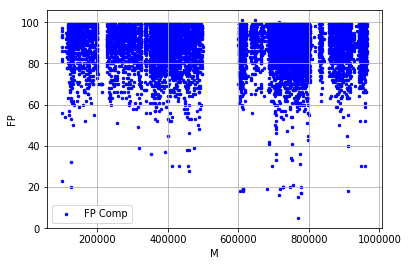

In [82]:
import matplotlib.pyplot as plt
# 2 - Create plot. 
a = 1
if a == 0: 
    plt.hist(Y)
else: 
    plt.xlabel('M')
    plt.ylabel('FP')
    plt.grid(True)
    N = 2 #50
    colors = np.random.rand(N)
    area = 1 #np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii

    #plt.plot(X, Y, color='blue', marker='o', label='FP Comp')
    #plt.plot(X, Y, 'bo', label='FP Comp')
    plt.scatter(X,Y, s=6, c='b', marker='o', cmap=None, norm=None, vmin=60, vmax=101, alpha=None,  label='FP Comp')
    # plt.plot(X, Y,  s=area, c=colors, alpha=0.5) #'bo', label='FP Comp',
    plt.legend()

# 3 - Display plot. 

plt.show()